# 01_EDA – Exploratory Data Analysis on Login Event Data

This notebook performs exploratory data analysis (EDA) on the RBA login dataset to understand user login behaviors, identify key patterns, and prepare the data for anomaly detection using machine learning.

### Objectives:
- Inspect dataset structure and types
- Analyze login distributions by country, time, and user behavior
- Visualize geo-based and temporal login trends
- Identify potential indicators of malicious activity (e.g., rare locations, odd login hours)
- Guide feature engineering for downstream ML models

**Imports**:

In [1]:
# Standart Imports
import dask.dataframe as dd
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

**Load the Dataset**:

In [2]:
df = dd.read_csv('../data/rba-dataset.csv')
df.head()

,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,0,2020-02-03 12:43:30.772,-4324475583306591935,NaN,10.0.65.171,NO,-,-,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Firefox 20.0.0.1618,iOS 13.4,mobile,False,False,False
1,1,2020-02-03 12:43:43.549,-4324475583306591935,NaN,194.87.207.6,AU,-,-,60117,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile 46.0.2490,Android 4.1,mobile,False,False,False
2,2,2020-02-03 12:43:55.873,-3284137479262433373,NaN,81.167.144.58,NO,Vestland,Urangsvag,29695,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,Android 2.3.3.2672,iOS 7.1,mobile,True,False,False
3,3,2020-02-03 12:43:56.180,-4324475583306591935,NaN,170.39.78.152,US,-,-,393398,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile WebView 85.0.4183,Android 4.1,mobile,False,False,False
4,4,2020-02-03 12:43:59.396,-4618854071942621186,NaN,10.0.0.47,US,Virginia,Ashburn,398986,Mozilla/5.0 (Linux; U; Android 2.2) Build/NMA...,Chrome Mobile WebView 85.0.4183,Android 2.2,mobile,False,True,False


**Basic EDA**:

In [3]:
df.info()

<class 'dask.dataframe.dask_expr.DataFrame'>
Columns: 16 entries, index to Is Account Takeover
dtypes: bool(3), float64(1), int64(3), string(9)

In [4]:
df.describe().compute()

,index,User ID,Round-Trip Time [ms],ASN
count,3.126926e+07,3.126926e+07,1.275935e+06,3.126926e+07
mean,1.563463e+07,-2.689563e+11,6.639332e+02,1.621215e+05
std,9.026659e+06,4.514276e+18,1.116125e+03,1.719185e+05
min,0.000000e+00,-9.223371e+18,8.000000e+00,1.200000e+01
25%,7.814304e+06,-4.324476e+18,4.740000e+02,2.969500e+04
50%,1.558211e+07,-4.324476e+18,5.440000e+02,2.071740e+05
75%,2.344399e+07,2.293924e+18,6.970000e+02,3.933980e+05
max,3.126926e+07,9.223359e+18,2.234570e+05,5.077270e+05


C:\Users\emrev\PycharmProjects\ML-SIEM\.venv\lib\site-packages\dask\dataframe\core.py:382: UserWarning: Insufficient elements for `head`. 20 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(
C:\Users\emrev\PycharmProjects\ML-SIEM\.venv\lib\site-packages\dask\dataframe\core.py:382: UserWarning: Insufficient elements for `head`. 20 elements requested, only 0 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [5]:
df.columns

Index(['index', 'Login Timestamp', 'User ID', 'Round-Trip Time [ms]',
       'IP Address', 'Country', 'Region', 'City', 'ASN', 'User Agent String',
       'Browser Name and Version', 'OS Name and Version', 'Device Type',
       'Login Successful', 'Is Attack IP', 'Is Account Takeover'],
      dtype='object')

In [6]:
df.dtypes

index                                 int64
Login Timestamp             string[pyarrow]
User ID                               int64
Round-Trip Time [ms]                float64
IP Address                  string[pyarrow]
Country                     string[pyarrow]
Region                      string[pyarrow]
City                        string[pyarrow]
ASN                                   int64
User Agent String           string[pyarrow]
Browser Name and Version    string[pyarrow]
OS Name and Version         string[pyarrow]
Device Type                 string[pyarrow]
Login Successful                       bool
Is Attack IP                           bool
Is Account Takeover                    bool
dtype: object

In [7]:
# Check NaN
df.isna().sum().compute()

index                              0
Login Timestamp                    0
User ID                            0
Round-Trip Time [ms]        29993329
IP Address                         0
Country                            0
Region                         47409
City                            8590
ASN                                0
User Agent String                  0
Browser Name and Version           0
OS Name and Version                0
Device Type                     1526
Login Successful                   0
Is Attack IP                       0
Is Account Takeover                0
dtype: int64

In [8]:
# Length of the full dataset
len(df)

31269264

In [9]:
# Check the value count of User ID
df["User ID"].value_counts().compute().describe()

count    4.304857e+06
mean     7.263717e+00
std      6.760161e+03
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      1.402590e+07
Name: count, dtype: float64

In the next steps, I will clean and transform the dataset based on early observations:

* `User ID` will be kept as there are approximently 7 rows for each user.
* `Round-Trip Time [ms]` contains too many missing values (over 95%) and will be dropped.
* `Region` and `City` are partially missing and less useful compared to `Country`, which I’ll retain as the primary geolocation feature.
* `User Agent String` will be dropped since I already have separate columns for browser, OS, and device type.
* I may extract major versions from browser or OS strings later if needed, but for now I’ll keep them as-is.
* `Is Attack IP` will be kept to help label or validate suspicious activity.
* Finally, I’ll drop the `index` column as it doesn’t serve any purpose.

For time-based analysis, I will extract only the hour from the `Login Timestamp`. Using year, month, or day likely won’t add meaningful patterns, while minute or second would be overly granular and introduce noise. Hour-level granularity should be sufficient to identify suspicious login times.

# Feature Engineering

In this part, we will clear the dataset and make it ready for further analyzing and visualization.

**Drop Columns**:

In [10]:
dropped_columns = ["index", "Round-Trip Time [ms]", "Region", "City", "User Agent String", "ASN", "User ID"]
df = df.drop(columns=dropped_columns)

In [11]:
df.head()

,Login Timestamp,IP Address,Country,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,2020-02-03 12:43:30.772,10.0.65.171,NO,Firefox 20.0.0.1618,iOS 13.4,mobile,False,False,False
1,2020-02-03 12:43:43.549,194.87.207.6,AU,Chrome Mobile 46.0.2490,Android 4.1,mobile,False,False,False
2,2020-02-03 12:43:55.873,81.167.144.58,NO,Android 2.3.3.2672,iOS 7.1,mobile,True,False,False
3,2020-02-03 12:43:56.180,170.39.78.152,US,Chrome Mobile WebView 85.0.4183,Android 4.1,mobile,False,False,False
4,2020-02-03 12:43:59.396,10.0.0.47,US,Chrome Mobile WebView 85.0.4183,Android 2.2,mobile,False,True,False


In [12]:
df.columns

Index(['Login Timestamp', 'IP Address', 'Country', 'Browser Name and Version',
       'OS Name and Version', 'Device Type', 'Login Successful',
       'Is Attack IP', 'Is Account Takeover'],
      dtype='object')

**Extract Hour and Day of the Week**:

In [13]:
df['Login Timestamp'] = dd.to_datetime(df['Login Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')

In [14]:
df.head()

,Login Timestamp,IP Address,Country,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,2020-02-03 12:43:30.772,10.0.65.171,NO,Firefox 20.0.0.1618,iOS 13.4,mobile,False,False,False
1,2020-02-03 12:43:43.549,194.87.207.6,AU,Chrome Mobile 46.0.2490,Android 4.1,mobile,False,False,False
2,2020-02-03 12:43:55.873,81.167.144.58,NO,Android 2.3.3.2672,iOS 7.1,mobile,True,False,False
3,2020-02-03 12:43:56.180,170.39.78.152,US,Chrome Mobile WebView 85.0.4183,Android 4.1,mobile,False,False,False
4,2020-02-03 12:43:59.396,10.0.0.47,US,Chrome Mobile WebView 85.0.4183,Android 2.2,mobile,False,True,False


In [15]:
df['login_hours'] = df['Login Timestamp'].dt.hour
df['login_day'] = df['Login Timestamp'].dt.weekday
df.head()

,Login Timestamp,IP Address,Country,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover,login_hours,login_day
0,2020-02-03 12:43:30.772,10.0.65.171,NO,Firefox 20.0.0.1618,iOS 13.4,mobile,False,False,False,12,0
1,2020-02-03 12:43:43.549,194.87.207.6,AU,Chrome Mobile 46.0.2490,Android 4.1,mobile,False,False,False,12,0
2,2020-02-03 12:43:55.873,81.167.144.58,NO,Android 2.3.3.2672,iOS 7.1,mobile,True,False,False,12,0
3,2020-02-03 12:43:56.180,170.39.78.152,US,Chrome Mobile WebView 85.0.4183,Android 4.1,mobile,False,False,False,12,0
4,2020-02-03 12:43:59.396,10.0.0.47,US,Chrome Mobile WebView 85.0.4183,Android 2.2,mobile,False,True,False,12,0


**Browser Name / Version and OS Name / Version**:

In [16]:
df['browser_name'] = df['Browser Name and Version'].str.extract(r'^([^\d]*\d*\s?[A-Za-z]+)', expand=False)
df.head()

,Login Timestamp,IP Address,Country,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover,login_hours,login_day,browser_name
0,2020-02-03 12:43:30.772,10.0.65.171,NO,Firefox 20.0.0.1618,iOS 13.4,mobile,False,False,False,12,0,Firefox
1,2020-02-03 12:43:43.549,194.87.207.6,AU,Chrome Mobile 46.0.2490,Android 4.1,mobile,False,False,False,12,0,Chrome Mobile
2,2020-02-03 12:43:55.873,81.167.144.58,NO,Android 2.3.3.2672,iOS 7.1,mobile,True,False,False,12,0,Android
3,2020-02-03 12:43:56.180,170.39.78.152,US,Chrome Mobile WebView 85.0.4183,Android 4.1,mobile,False,False,False,12,0,Chrome Mobile WebView
4,2020-02-03 12:43:59.396,10.0.0.47,US,Chrome Mobile WebView 85.0.4183,Android 2.2,mobile,False,True,False,12,0,Chrome Mobile WebView


In [17]:
df['OS_name'] = df['OS Name and Version'].str.extract(r'^(.*?)(?:\s+\d+.*)?$', expand=False).str.strip()
df.head()

,Login Timestamp,IP Address,Country,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover,login_hours,login_day,browser_name,OS_name
0,2020-02-03 12:43:30.772,10.0.65.171,NO,Firefox 20.0.0.1618,iOS 13.4,mobile,False,False,False,12,0,Firefox,iOS
1,2020-02-03 12:43:43.549,194.87.207.6,AU,Chrome Mobile 46.0.2490,Android 4.1,mobile,False,False,False,12,0,Chrome Mobile,Android
2,2020-02-03 12:43:55.873,81.167.144.58,NO,Android 2.3.3.2672,iOS 7.1,mobile,True,False,False,12,0,Android,iOS
3,2020-02-03 12:43:56.180,170.39.78.152,US,Chrome Mobile WebView 85.0.4183,Android 4.1,mobile,False,False,False,12,0,Chrome Mobile WebView,Android
4,2020-02-03 12:43:59.396,10.0.0.47,US,Chrome Mobile WebView 85.0.4183,Android 2.2,mobile,False,True,False,12,0,Chrome Mobile WebView,Android


In [18]:
df[df['browser_name'].isna()][['Browser Name and Version']].head(20)

,Browser Name and Version


In [19]:
df[df['OS_name'].isna()][['OS Name and Version']].head(20)

,OS Name and Version


In [20]:
# Split IP into 4 octets using Dask string methods (vectorized & fast)
octets = df['IP Address'].str.split('.', n=3, expand=True, )

# Convert and normalize each part
for i in range(4):
    df[f'ip_{i+1}'] = octets[i].astype(float) / 255.0

As we have done the feature engineering, we will drop the columns like `Login Timestamp`, `Browser Name and Version`, and so on. We will also rename the columns. E.g. `Is Attack IP` becomes `is_attack_ip`.

In [21]:
dropped_columns = ["Login Timestamp", "IP Address", "Browser Name and Version", "OS Name and Version"]
df = df.drop(columns=dropped_columns)

In [22]:
df.head()

,Country,Device Type,Login Successful,Is Attack IP,Is Account Takeover,login_hours,login_day,browser_name,OS_name,ip_1,ip_2,ip_3,ip_4
0,NO,mobile,False,False,False,12,0,Firefox,iOS,0.039216,0.000000,0.254902,0.670588
1,AU,mobile,False,False,False,12,0,Chrome Mobile,Android,0.760784,0.341176,0.811765,0.023529
2,NO,mobile,True,False,False,12,0,Android,iOS,0.317647,0.654902,0.564706,0.227451
3,US,mobile,False,False,False,12,0,Chrome Mobile WebView,Android,0.666667,0.152941,0.305882,0.596078
4,US,mobile,False,True,False,12,0,Chrome Mobile WebView,Android,0.039216,0.000000,0.000000,0.184314


**Rename Columns**:

In [23]:
# Rename Dictionary
rename_dict = {
    "Country": "country_code",
    "Device Type": "device_type",
    "Login Successful": "is_login_success",
    "Is Attack IP": "is_attack_ip",
    "Is Account Takeover": "is_account_takeover",
    "OS_name": "os_name",
}

df = df.rename(columns=rename_dict)

In [24]:
df.head()

,country_code,device_type,is_login_success,is_attack_ip,is_account_takeover,login_hours,login_day,browser_name,os_name,ip_1,ip_2,ip_3,ip_4
0,NO,mobile,False,False,False,12,0,Firefox,iOS,0.039216,0.000000,0.254902,0.670588
1,AU,mobile,False,False,False,12,0,Chrome Mobile,Android,0.760784,0.341176,0.811765,0.023529
2,NO,mobile,True,False,False,12,0,Android,iOS,0.317647,0.654902,0.564706,0.227451
3,US,mobile,False,False,False,12,0,Chrome Mobile WebView,Android,0.666667,0.152941,0.305882,0.596078
4,US,mobile,False,True,False,12,0,Chrome Mobile WebView,Android,0.039216,0.000000,0.000000,0.184314


**Optimize the data**:

In [25]:
df.dtypes

country_code           string[pyarrow]
device_type            string[pyarrow]
is_login_success                object
is_attack_ip                    object
is_account_takeover             object
login_hours                      int32
login_day                        int32
browser_name           string[pyarrow]
os_name                string[pyarrow]
ip_1                           float64
ip_2                           float64
ip_3                           float64
ip_4                           float64
dtype: object

In [26]:
# Check NaN
df.isna().sum().compute()

country_code              0
device_type            1526
is_login_success          0
is_attack_ip              0
is_account_takeover       0
login_hours               0
login_day                 0
browser_name              8
os_name                   0
ip_1                      0
ip_2                      0
ip_3                      0
ip_4                      0
dtype: int64

In [27]:
# Drop NaN
df = df.dropna()

In [28]:
# Verify drop NaN
df.isna().sum().compute()

country_code           0
device_type            0
is_login_success       0
is_attack_ip           0
is_account_takeover    0
login_hours            0
login_day              0
browser_name           0
os_name                0
ip_1                   0
ip_2                   0
ip_3                   0
ip_4                   0
dtype: int64

In [29]:
# Optimize the data types

# Object -> Bool
df['is_login_success'] = df['is_login_success'].astype('bool')
df['is_attack_ip'] = df['is_attack_ip'].astype('bool')
df['is_account_takeover'] = df['is_account_takeover'].astype('bool')

# Int32 -> Uint8
df['login_day'] = df['login_day'].astype('uint8')
df['login_hours'] = df['login_hours'].astype('uint8')

# String -> Category
df['country_code'] = df['country_code'].astype('category')

In [30]:
# Verify
df.dtypes

country_code                  category
device_type            string[pyarrow]
is_login_success                  bool
is_attack_ip                      bool
is_account_takeover               bool
login_hours                      uint8
login_day                        uint8
browser_name           string[pyarrow]
os_name                string[pyarrow]
ip_1                           float64
ip_2                           float64
ip_3                           float64
ip_4                           float64
dtype: object

In [31]:
df.head()

,country_code,device_type,is_login_success,is_attack_ip,is_account_takeover,login_hours,login_day,browser_name,os_name,ip_1,ip_2,ip_3,ip_4
0,NO,mobile,False,False,False,12,0,Firefox,iOS,0.039216,0.000000,0.254902,0.670588
1,AU,mobile,False,False,False,12,0,Chrome Mobile,Android,0.760784,0.341176,0.811765,0.023529
2,NO,mobile,True,False,False,12,0,Android,iOS,0.317647,0.654902,0.564706,0.227451
3,US,mobile,False,False,False,12,0,Chrome Mobile WebView,Android,0.666667,0.152941,0.305882,0.596078
4,US,mobile,False,True,False,12,0,Chrome Mobile WebView,Android,0.039216,0.000000,0.000000,0.184314


**Save the Dataset**:

In [32]:
df.to_csv('../data/processed/', index=False)

['C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\000.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\001.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\002.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\003.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\004.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\005.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\006.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\007.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\008.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\009.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\010.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\011.part',
 'C:\\Users\\emrev\\PycharmProjects\\ML-SIEM\\data\\processed\\012.part',
 'C:\\Users\\emrev\\PycharmProjects\\M

In this stage, we prepared the dataset for deeper analysis by performing several key operations. First, we **dropped unnecessary columns** such as raw timestamps, user agents, and original browser/OS info after extracting the relevant parts. We then **renamed columns** to follow a consistent and readable naming convention (e.g., `User ID` → `user_id`). From selected columns, we **derived new features** like `login_hours`, `login_day`, `browser_name`, and `os_name` to capture essential patterns while reducing noise. Next, we **removed rows with missing values** to maintain data quality. Finally, we **optimized data types** — converting numerical columns to appropriate integer types, booleans to native `bool`, and string columns with low cardinality to `category` — to enhance performance and reduce memory usage.

# Visualization

In this section, we will explore the dataset visually to uncover hidden patterns, trends, and anomalies that might not be immediately apparent through raw numbers. We'll use plots and charts to analyze relationships between features, understand the distribution of attacks, and identify key behavioral differences between normal and malicious logins. These insights will guide future feature selection and model design.

**Account Takeover Distribution**:

In [33]:
total_takeovers = df['is_account_takeover'].value_counts().compute()

In [34]:
total_takeovers

is_account_takeover
True          141
False    31267589
Name: count, dtype: int64

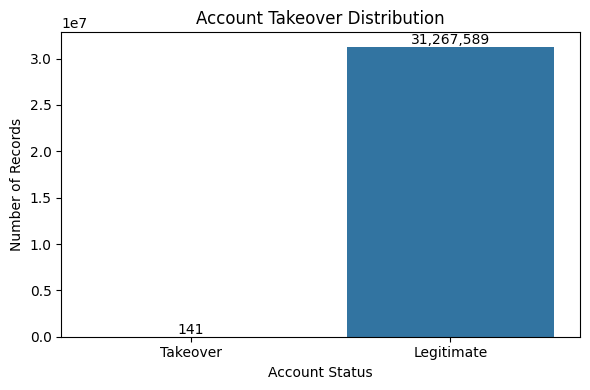

In [35]:
# Create Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=total_takeovers.index.map({False: 'Legitimate', True: 'Takeover'}), y=total_takeovers.values)

# Add labels
plt.title("Account Takeover Distribution")
plt.xlabel("Account Status")
plt.ylabel("Number of Records")

# Anotate the bars
for i, val in enumerate(total_takeovers.values):
    plt.text(i, val, f'{val:,}', ha='center', va='bottom')

# Save the plot
plt.savefig("../images/account_takeover_distribution.png")

# Show the plot
plt.tight_layout()
plt.show()

As visualized, the dataset is extremely imbalanced, with only **141 account takeover records** out of over **31 million total login events**. This makes traditional supervised classification approaches ineffective, as the model would overwhelmingly favor the majority class. Given this level of imbalance, `anomaly detection` techniques are more appropriate, as they treat attacks as rare, outlying events in otherwise normal login behavior.

**Top 10 Countries by Legitimate and Takeovers**:

In [36]:
df['country_code'].unique().compute()

0    SE
1    FO
0    PR
1    TW
0    TR
     ..
1    LV
2    YE
0    SC
0    BJ
1    GU
Name: country_code, Length: 229, dtype: category
Categories (229, string): [AE, AF, AG, AL, ..., FM, MS, DM, NR]

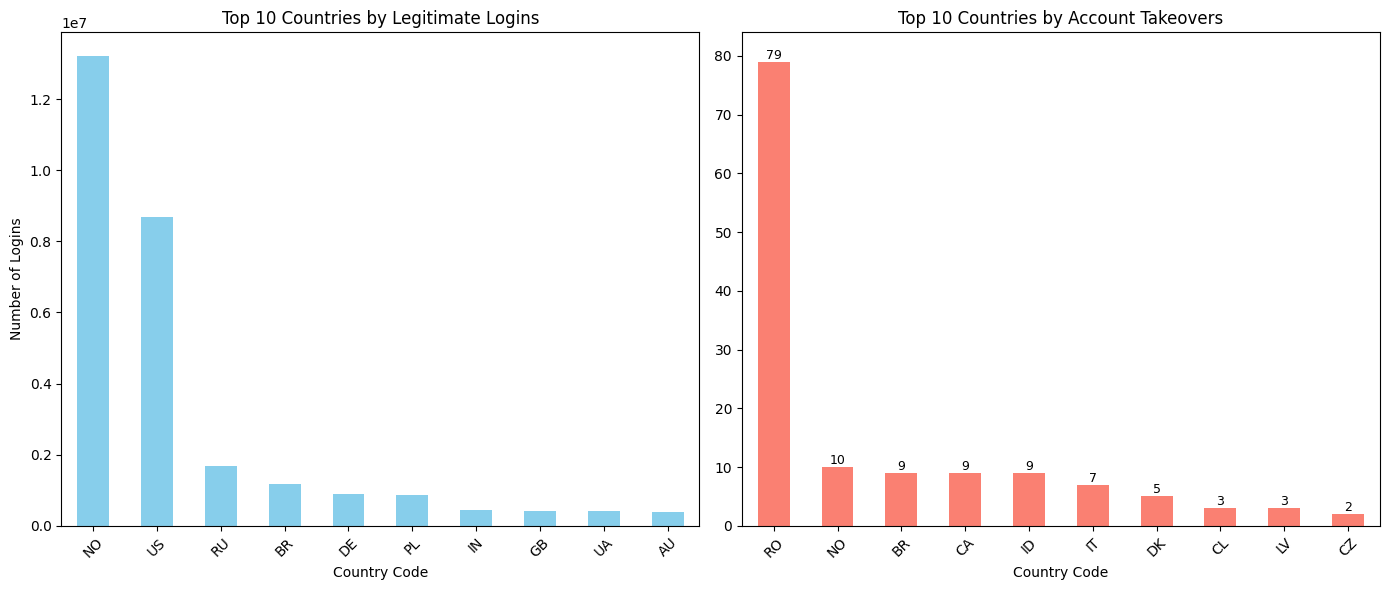

In [37]:
# Convert to string for visualization
df['country_code'] = df['country_code'].astype(str)

# Group data
country_takeover_split = (
    df.groupby(['country_code', 'is_account_takeover'])
    .size()
    .compute()
    .unstack(fill_value=0)
)

# Get top 10 legitimate and takeover countries
top_legit = country_takeover_split[False].nlargest(10)
top_takeover = country_takeover_split[True].nlargest(10)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=False)

# Plot legitimate
top_legit.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Top 10 Countries by Legitimate Logins")
axes[0].set_xlabel("Country Code")
axes[0].set_ylabel("Number of Logins")
axes[0].tick_params(axis='x', rotation=45)

# Plot takeover (with tighter y-limit)
top_takeover.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title("Top 10 Countries by Account Takeovers")
axes[1].set_xlabel("Country Code")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim([0, top_takeover.max() + 5])  # Zoom in on small counts

# Optional: Annotate bar values on takeover plot
for idx, val in enumerate(top_takeover):
    axes[1].text(idx, val + 0.5, str(val), ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../images/top_10_country_legit_vs_takeover_split.png')
plt.show()

The visualization shows that the majority of legitimate logins originate from Norway (NO) and the United States (US), with Norway leading significantly. In contrast, Romania (RO) stands out as the top source of account takeovers, far exceeding other countries in takeover counts. This highlights a strong geographic disparity between normal and malicious login behaviors.

**Login Distributions Legit vs Takeover**:

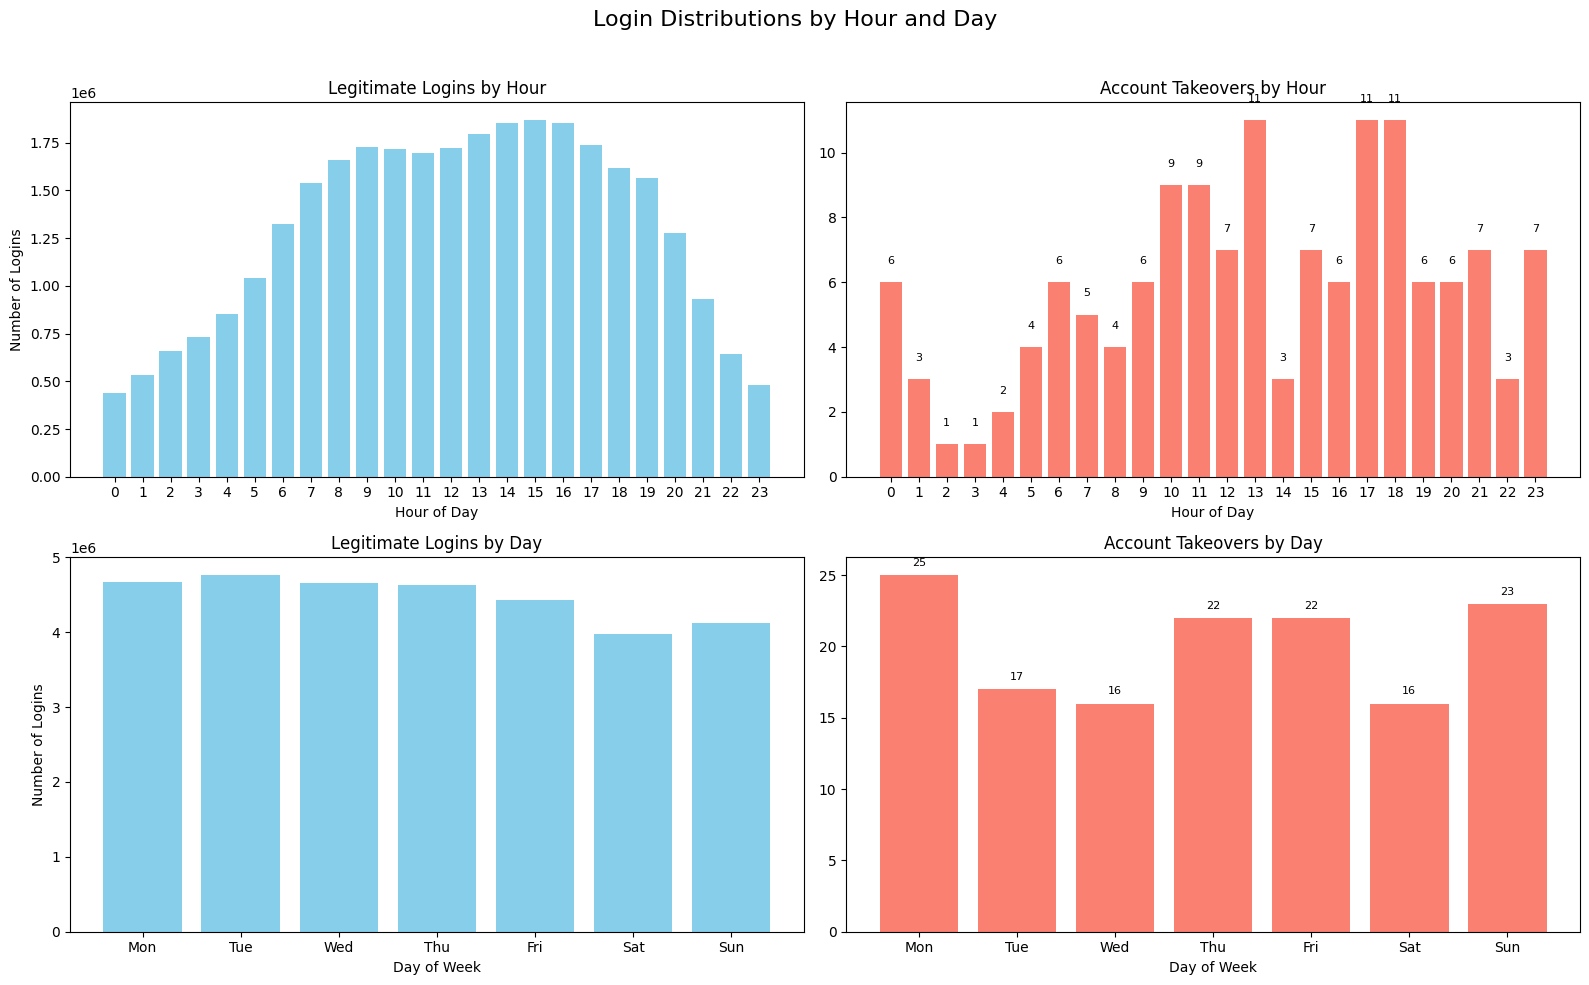

In [38]:
# Make them int for grouping
df['login_hours'] = df['login_hours'].astype(int)
df['login_day'] = df['login_day'].astype(int)

# Filter for legitimate and takeover
df_legit = df[df['is_account_takeover'] == False]
df_takeover = df[df['is_account_takeover'] == True]

# Group by login_hour and login_day
hour_legit = df_legit['login_hours'].value_counts().compute().sort_index()
hour_takeover = df_takeover['login_hours'].value_counts().compute().sort_index()

all_days = list(range(0, 7))
day_legit = df_legit['login_day'].value_counts().compute().reindex(all_days, fill_value=0)
day_takeover = df_takeover['login_day'].value_counts().compute().reindex(all_days, fill_value=0)

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Login Distributions by Hour and Day', fontsize=16)

# 1. Legitimate logins by hour
axes[0, 0].bar(hour_legit.index, hour_legit.values, color='skyblue')
axes[0, 0].set_title('Legitimate Logins by Hour')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Logins')
axes[0, 0].set_xticks(range(0, 24))

# 2. Takeover logins by hour
axes[0, 1].bar(hour_takeover.index, hour_takeover.values, color='salmon')
axes[0, 1].set_title('Account Takeovers by Hour')
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_xticks(range(0, 24))
for x, y in zip(hour_takeover.index, hour_takeover.values):
    axes[0, 1].text(x, y + 0.5, str(y), ha='center', va='bottom', fontsize=8)

day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# 3. Legitimate logins by day
axes[1, 0].bar(day_legit.index, day_legit.values, color='skyblue')
axes[1, 0].set_title('Legitimate Logins by Day')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Number of Logins')
axes[1, 0].set_xticks(range(0, 7))
axes[1, 0].set_xticklabels(day_names)

# 4. Takeover logins by day
axes[1, 1].bar(day_takeover.index, day_takeover.values, color='salmon')
axes[1, 1].set_title('Account Takeovers by Day')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_xticks(range(0, 7))
axes[1, 1].set_xticklabels(day_names)
for x, y in zip(day_takeover.index, day_takeover.values):
    axes[1, 1].text(x, y + 0.5, str(y), ha='center', va='bottom', fontsize=8)

# Show and Save Plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../images/login_distributions_legit_vs_takeover.png')
plt.show()

The majority of legitimate logins occur during typical business hours (07:00–19:00), indicating user activity aligns with standard work schedules. In contrast, while account takeovers are too few to draw strong conclusions, there’s a relatively higher presence during late-night hours (23:00 and 00:00) compared to legitimate traffic. When analyzing by day of the week, login activity is fairly consistent for both categories. However, legitimate logins slightly dip on weekends, while account takeovers slightly increase on Sunday and Monday, potentially hinting at off-peak attack timing.

**Distribution by Device, Browser, and OS for Legitimate vs Takeover Logins**:

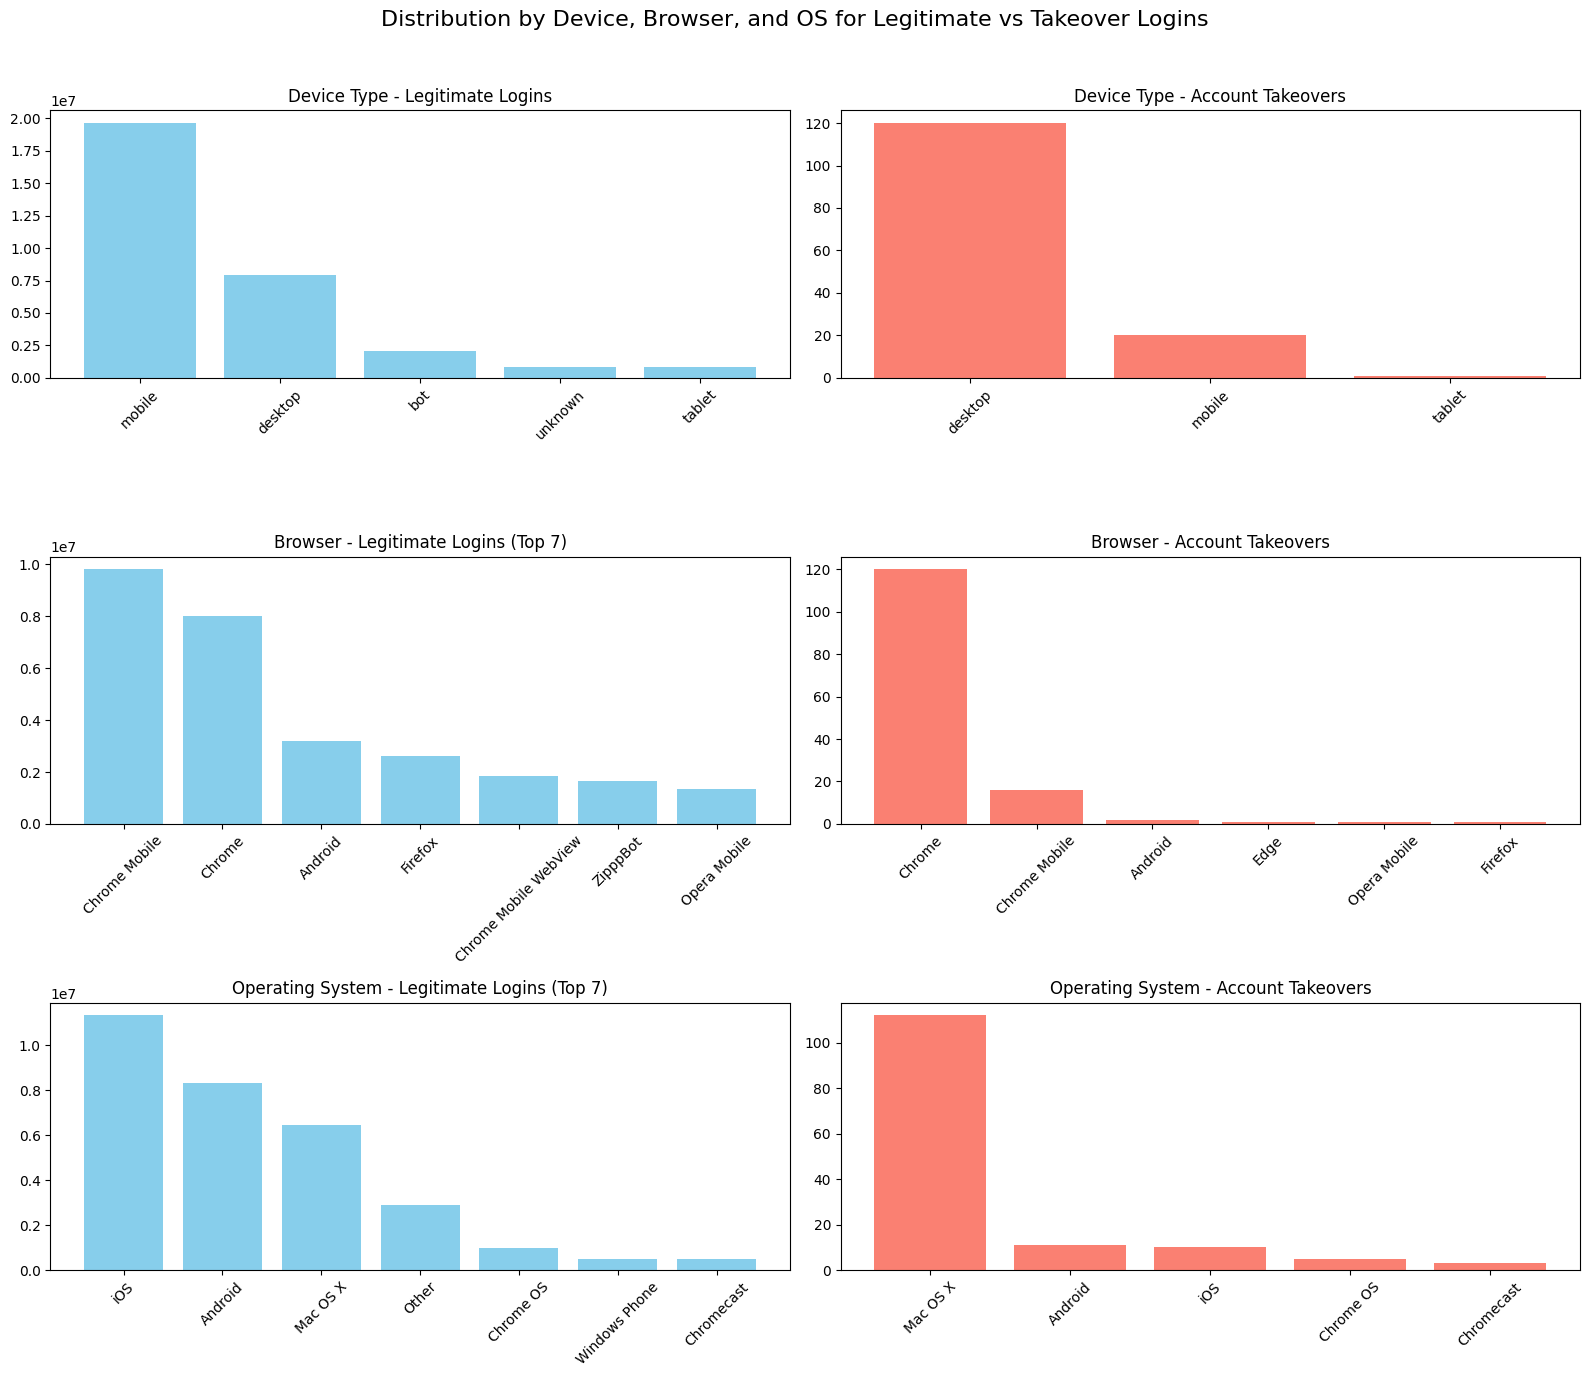

In [39]:
# Filter data
df_legit = df[df['is_account_takeover'] == False]
df_takeover = df[df['is_account_takeover'] == True]

# Compute counts
device_legit = df_legit['device_type'].value_counts().compute().sort_values(ascending=False)
device_takeover = df_takeover['device_type'].value_counts().compute().sort_values(ascending=False)

browser_legit = df_legit['browser_name'].value_counts().compute().sort_values(ascending=False).head(7)
browser_takeover = df_takeover['browser_name'].value_counts().compute().sort_values(ascending=False)

os_legit = df_legit['os_name'].value_counts().compute().sort_values(ascending=False).head(7)
os_takeover = df_takeover['os_name'].value_counts().compute().sort_values(ascending=False)

# Create 3x2 subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
fig.suptitle("Distribution by Device, Browser, and OS for Legitimate vs Takeover Logins", fontsize=16)

# 1,1: Device type - Legitimate
axes[0, 0].bar(device_legit.index, device_legit.values, color='skyblue')
axes[0, 0].set_title("Device Type - Legitimate Logins")
axes[0, 0].tick_params(axis='x', rotation=45)

# 1,2: Device type - Takeover
axes[0, 1].bar(device_takeover.index, device_takeover.values, color='salmon')
axes[0, 1].set_title("Device Type - Account Takeovers")
axes[0, 1].tick_params(axis='x', rotation=45)

# 2,1: Browser - Legitimate (Top 7)
axes[1, 0].bar(browser_legit.index, browser_legit.values, color='skyblue')
axes[1, 0].set_title("Browser - Legitimate Logins (Top 7)")
axes[1, 0].tick_params(axis='x', rotation=45)

# 2,2: Browser - Takeover
axes[1, 1].bar(browser_takeover.index, browser_takeover.values, color='salmon')
axes[1, 1].set_title("Browser - Account Takeovers")
axes[1, 1].tick_params(axis='x', rotation=45)

# 3,1: OS - Legitimate (Top 7)
axes[2, 0].bar(os_legit.index, os_legit.values, color='skyblue')
axes[2, 0].set_title("Operating System - Legitimate Logins (Top 7)")
axes[2, 0].tick_params(axis='x', rotation=45)

# 3,2: OS - Takeover
axes[2, 1].bar(os_takeover.index, os_takeover.values, color='salmon')
axes[2, 1].set_title("Operating System - Account Takeovers")
axes[2, 1].tick_params(axis='x', rotation=45)

# Final layout adjustments and save
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('../images/device_browser_os_legit_vs_takeover.png')
plt.show()

The analysis reveals that most legitimate users access the platform via mobile devices, especially using Chrome Mobile on iOS, which aligns with common user behavior on smartphones. In contrast, account takeovers predominantly occur through desktop devices, primarily using the Chrome browser on Mac OS X. This shift suggests that attackers likely use more advanced setups — possibly tools or scripts — that are better suited for desktops. Interestingly, the high use of Mac OS X for takeovers is unexpected, as Linux is often associated with such activities, indicating a unique attacker profile or environment in this dataset.

**Distribution of Successful Logins**:

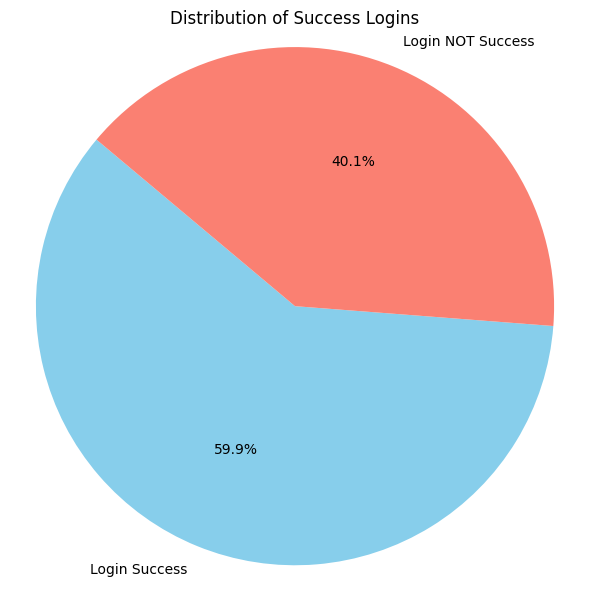

In [40]:
# Count values for is_attack_ip
success_login_counts = df['is_login_success'].value_counts().compute()
success_login_counts = success_login_counts.sort_index()

# Define labels and colors
labels = ['Login Success', 'Login NOT Success']
colors = ['skyblue', 'salmon']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(success_login_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Success Logins')
plt.axis('equal')
plt.tight_layout()
plt.savefig('../images/is_login_success_pie_chart.png')
plt.show()

**Distribution of Attack IPs**:

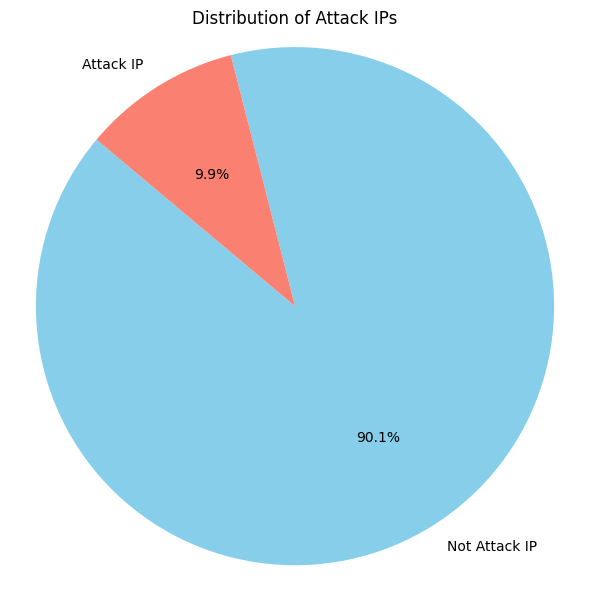

In [41]:
# Count values for is_attack_ip
attack_ip_counts = df['is_attack_ip'].value_counts().compute()
attack_ip_counts = attack_ip_counts.sort_index()

# Define labels and colors
labels = ['Not Attack IP', 'Attack IP']
colors = ['skyblue', 'salmon']

# Plot
plt.figure(figsize=(6, 6))
plt.pie(attack_ip_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Attack IPs')
plt.axis('equal')
plt.tight_layout()
plt.savefig('../images/is_attack_ip_pie_chart.png')
plt.show()

In [42]:
attack_ip_counts

is_attack_ip
False    28171262
True      3096468
Name: count, dtype: int64

While only a small fraction of logins are actual account takeovers, a much larger proportion (~9.9%) of the login traffic is flagged as coming from attack IPs. This indicates that many IPs are suspected to be malicious even though most logins from them do not result in successful takeovers. This discrepancy suggests that the is_attack_ip label may be overly broad or conservatively flagged, possibly due to IP reputation lists or prior activity. From a modeling perspective, this may introduce noise or false signals if the model overemphasizes is_attack_ip. However, this could also be beneficial — enabling the model to learn nuanced differences between truly malicious behavior and false positives, ultimately improving generalization if handled properly (e.g., through feature weighting or regularization).